In [239]:
import pandas as pd
import geopandas as gpd
import datetime as dt
import numpy as np
import math
from shapely.geometry import Polygon, MultiPolygon
from matplotlib import pyplot as plt, ticker
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut

In [5]:
fortaleza = gpd.read_file('Dados/Densidade_Populacional_por_Bairros.zip')

In [6]:
def arred_baixo(num, dec):
    return math.floor(num * 10 ** dec) / 10 ** dec

In [7]:
def criar_celula(lat, lng, passo):
    return Polygon([(lat, lng), (lat + passo, lng), (lat + passo, lng + passo), (lat, lng + passo)])

In [8]:
x_min, y_min, x_max, y_max = (arred_baixo(b, 2) for b in fortaleza.geometry.unary_union.bounds)

In [9]:
p = 0.01

In [11]:
grade_completa = MultiPolygon((criar_celula(x, y, p) for x in np.arange(x_min - p, x_max + p, p) for y in np.arange(y_min - p, y_max + p, p)))   

In [12]:
grade_fortaleza = MultiPolygon([c for c in grade_completa.geoms if c.intersects(fortaleza.unary_union)])

<AxesSubplot:>

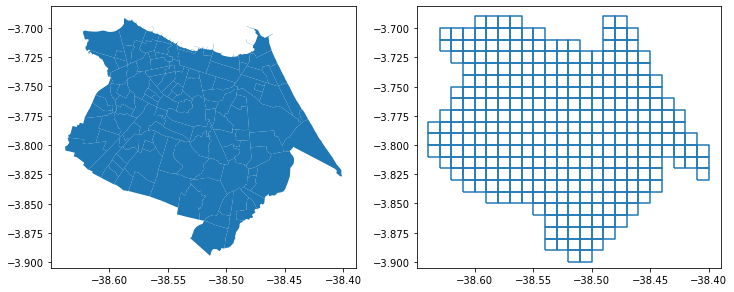

In [43]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

fortaleza.plot(ax=ax1)
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())
gpd.GeoSeries(grade_fortaleza).boundary.plot(ax=ax2)

In [245]:
pedidos_fortaleza = pd.read_csv('Dados/New_query_2023_07_11.csv', parse_dates=['ini_pedido', 'fim_pedido'])

In [248]:
pedidos_por_rest = pedidos_fortaleza['frn_id'].value_counts().reset_index().rename(columns={"index": 'frn_id', "frn_id": 'pedidos'})

In [249]:
tamanho_amostra = 1

In [250]:
rests_amostra = pedidos_por_rest[pedidos_por_rest.pedidos > 3000][['frn_id']].drop_duplicates().sample(n=tamanho_amostra, random_state=123)

In [251]:
pedidos_amostra = pedidos_fortaleza.merge(rests_amostra, on='frn_id')

In [252]:
pedidos_amostra['hr_pedido'] = pedidos_amostra['ini_pedido'].dt.hour

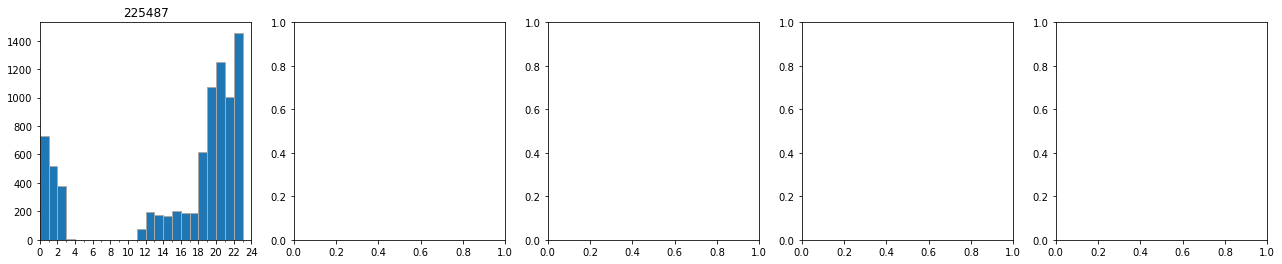

In [253]:
fig, axs = plt.subplots(nrows=max(1, math.floor(tamanho_amostra / 5)), ncols=5, figsize=(22, 4))
grupos_rests = pedidos_amostra.groupby('frn_id')

for (grp, df), ax in zip(grupos_rests, axs.ravel()):
    df['hr_pedido'].plot(kind='hist', bins=range(24), edgecolor='darkgrey', ax=ax)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_xlim((0, 24))
    ax.set_ylabel('')
    ax.set_title(grp)

In [302]:
def montar_janela(t0, m, delta_t):
    """
    Obtém uma janela de m datetimes iniciando em t0 e saltando a cada delta_t
    
    :param t0: momento inicial da janela
    :param m: número de momentos que compõem a janela
    :param delta_t: tamanho do salto de tempo entre cada momento t
    :returns: uma lista de momentos compondo uma janela
    """
    return [t0 + dt.timedelta(minutes=m) for m in range(0, m * delta_t, delta_t)]

In [340]:
def configurar_janela(df, ini, fim, lat, lng, t0, m, delta_t):
    """
    Obtém a configuração de estado de cada momento de uma janela
    
    :param df: dataframe com os dados para popular a janela
    :param ini: coluna com o início de cada evento
    :param fim: coluna com o término de cada evento
    :param lat: coluna com as latitudes do evento
    :param lng: coluna com as longitudes do evento
    :param t0: momento inicial da janela
    :param m: número de momentos que compõem a janela
    :param delta_t: tamanho do salto de tempo entre cada momento t
    :returns: uma janela com suas configurações em cada momento t
    """
    j = montar_janela(t0, m, delta_t)
    X = []
    
    for t in j:
        coords = df[(df[ini] <= t) & (df[fim] > t)][[lat, lng]].to_numpy()
        X.append({'t': t, 'n': len(coords), 'xy': coords})
        
    return X

In [341]:
janela = configurar_janela(pedidos_amostra, 'ini_pedido', 'fim_pedido', 'cli_lat', 'cli_lng', dt.datetime(2023, 1, 10, 22, 0, 0, 0), 30, 2)

In [343]:
janela

[{'t': datetime.datetime(2023, 1, 10, 22, 0),
  'n': 50,
  'xy': array([[ -3.816, -38.574],
         [ -3.792, -38.537],
         [ -3.781, -38.572],
         [ -3.775, -38.571],
         [ -3.774, -38.553],
         [ -3.765, -38.569],
         [ -3.781, -38.568],
         [ -3.765, -38.548],
         [ -3.778, -38.566],
         [ -3.807, -38.561],
         [ -3.767, -38.543],
         [ -3.772, -38.558],
         [ -3.803, -38.532],
         [ -3.781, -38.572],
         [ -3.784, -38.571],
         [ -3.765, -38.556],
         [ -3.82 , -38.605],
         [ -3.785, -38.57 ],
         [ -3.784, -38.57 ],
         [ -3.786, -38.569],
         [ -3.799, -38.553],
         [ -3.753, -38.567],
         [ -3.789, -38.548],
         [ -3.774, -38.553],
         [ -3.8  , -38.577],
         [ -3.792, -38.552],
         [ -3.765, -38.554],
         [ -3.783, -38.558],
         [ -3.782, -38.559],
         [ -3.807, -38.542],
         [ -3.776, -38.569],
         [ -3.778, -38.579],
         

In [290]:
janela = [{'dt': inicio_janela + dt.timedelta(minutes=m)} for m in range(0, 62, minutos_janela)]

In [291]:
for t in janela:
    t['state'] = pedidos_amostra[(pedidos_amostra.ini_pedido <= t['dt']) & (pedidos_amostra.fim_pedido > t['dt'])][['cli_lat', 'cli_lng']].to_numpy()

In [292]:
janela

[{'dt': datetime.datetime(2023, 1, 10, 22, 0),
  'obs': array([[ -3.816, -38.574],
         [ -3.792, -38.537],
         [ -3.781, -38.572],
         [ -3.775, -38.571],
         [ -3.774, -38.553],
         [ -3.765, -38.569],
         [ -3.781, -38.568],
         [ -3.765, -38.548],
         [ -3.778, -38.566],
         [ -3.807, -38.561],
         [ -3.767, -38.543],
         [ -3.772, -38.558],
         [ -3.803, -38.532],
         [ -3.781, -38.572],
         [ -3.784, -38.571],
         [ -3.765, -38.556],
         [ -3.82 , -38.605],
         [ -3.785, -38.57 ],
         [ -3.784, -38.57 ],
         [ -3.786, -38.569],
         [ -3.799, -38.553],
         [ -3.753, -38.567],
         [ -3.789, -38.548],
         [ -3.774, -38.553],
         [ -3.8  , -38.577],
         [ -3.792, -38.552],
         [ -3.765, -38.554],
         [ -3.783, -38.558],
         [ -3.782, -38.559],
         [ -3.807, -38.542],
         [ -3.776, -38.569],
         [ -3.778, -38.579],
         [ -3.758,

In [205]:
suavizacoes = 10 ** linspace(-1, 1, 10)
busca_bw = GridSearchCV(KernelDensity(kernel='gaussian', metric='haversine'), {'bandwidth': suavizacoes}, cv=LeaveOneOut())
busca_bw.fit(pedidos_amostra[['cli_lat', 'cli_lng']].to_numpy())

KeyboardInterrupt: 

In [207]:
pedidos_amostra[['cli_lat', 'cli_lng']]

,cli_lat,cli_lng
0,-3.822,-38.560
1,-3.791,-38.546
2,-3.795,-38.561
3,-3.793,-38.562
4,-3.771,-38.579
...,...,...
8223,-3.762,-38.567
8224,-3.792,-38.587
8225,-3.763,-38.568
8226,-3.800,-38.570
